In [1]:
import os
import pickle
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import torch
import itertools
from torch.autograd import Variable
import sklearn, sklearn.model_selection, sklearn.metrics
import numpy as np

from models.model_wrapper import WrappedModel
from data import datasets
from data.graph_wrapper import GeneManiaGraph
from data.utils import record_result

In [2]:
dataset = datasets.TCGADataset()
dataset.df = dataset.df - dataset.df.mean(axis=0)
label_df = dataset.df.where(dataset.df > 0).notnull().astype("int")


Checking for pieces on disk: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0%  finished
Found 1668 finished pieces out of 1668 total pieces.
Converting one-hot labels to integers


In [3]:
# Setup the results dictionary
filename = "experiments/results/fig-5.pkl"
try:
    results = pickle.load(open(filename, "r"))
    print "Loaded Checkpointed Results"
except Exception as e:
    results = pd.DataFrame(columns=['auc', 'gene', 'model', 'num_genes', 'seed', 'train_size'])
    print "Created a New Results Dictionary"


Loaded Checkpointed Results


In [4]:
gene_graph = GeneManiaGraph()

Checking for pieces on disk: |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0%  finished
Found 2034 finished pieces out of 2034 total pieces.


In [5]:
search_num_genes=[50, 100, 200, 300, 500, 1000, 2000, 4000, 8000, 16000]
test_size=1000
search_train_size=[50]
cuda=False
trials=5
search_genes = ["RPL13", "CEBPD", "IL5", "PABPC3", "PSMB10", "RPL4", "RPL5", "RPS10", "RPS3", "S100A8", "S100A9", "TOP1", "C15orf40", "RNF138", "DLGAP2", "EVI2B", "ZFP82", "MYBL2", "PSMB1", "CISD1", "HLA-B", "SAA2", "IFIT1", "RPS3A", "TP53", "TNF", "EGFR"]
model_list = [WrappedModel(name="GCN_lay3_chan64_emb32_dropout", cuda=cuda, num_layer=3, channels=64, embedding=32),
              WrappedModel(name="MLP_lay2_chan512_dropout", cuda=cuda, dropout=True, num_layer=2, channels=512),
              WrappedModel(name="MLP_lay2_chan512", cuda=cuda, dropout=False, num_layer=2, channels=512),
              WrappedModel(name="SLR_lambda1_l11", cuda=cuda),
              WrappedModel(name="GCN_lay20_chan32_emb32_dropout_pool", cuda=cuda, num_layer=4, channels=32, embedding=32, prepool_extralayers=5, pooling="ignore")  
             ]

In [6]:
# Create the set of all experiment ids and see which are left to do
model_names = [model.name for model in model_list]
columns = ["gene", "model", "num_genes", "train_size", "seed"]
all_exp_ids = [x for x in itertools.product(search_genes, model_names, search_num_genes, search_train_size, range(trials))]
all_exp_ids = pd.DataFrame(all_exp_ids, columns=columns)
all_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in all_exp_ids.itertuples(name=None)]
results_exp_ids = results[columns].copy()
results_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in results_exp_ids.itertuples(name=None)]
intersection_ids = all_exp_ids.index.intersection(results_exp_ids.index)
todo = all_exp_ids.drop(intersection_ids).to_dict(orient="records")
print("todo: " + str(len(todo)))
print("done: " + str(len(results)))

todo: 6629
done: 127


In [7]:
for row in todo:
    print row
    gene = row["gene"]
    model_name = row["model"]
    seed = row["seed"]
    num_genes = row["num_genes"]
    train_size = row["train_size"]

    model = [x for x in model_list if x.name == model_name][0]

    experiment = {
        "gene": gene,
        "model": model.name,
        "num_genes": num_genes,
        "train_size": train_size,
        "seed": seed,
    }

    dataset.labels = label_df[gene]
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size)

    neighbors, neighborhood = gene_graph.first_degree(gene)
    X_train = X_train[list(neighbors)].copy()
    X_test = X_test[list(neighbors)].copy()
    X_train[gene] = 1
    X_test[gene] = 1
    
    try:
        model.fit(X_train, y_train, adj=neighborhood)

        x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
        if cuda:
            x_test.cuda()
        y_hat = model.predict(x_test)[:,1].data.cpu().numpy()
        auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())

        model.best_model = None # cleanup
        experiment["auc"] = auc
    except Exception as e:
        print e
    results = record_result(results, experiment, filename)


{'train_size': 50, 'model': 'GCN_lay3_chan64_emb32_dropout', 'gene': 'RPL13', 'seed': 4, 'num_genes': 50}


/Users/martinweiss/.pyenv/versions/2.7.13/envs/venv27/lib/python2.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


{'train_size': 50, 'model': 'GCN_lay3_chan64_emb32_dropout', 'gene': 'RPL13', 'seed': 0, 'num_genes': 100}
{'train_size': 50, 'model': 'GCN_lay3_chan64_emb32_dropout', 'gene': 'RPL13', 'seed': 1, 'num_genes': 100}


KeyboardInterrupt: 

216


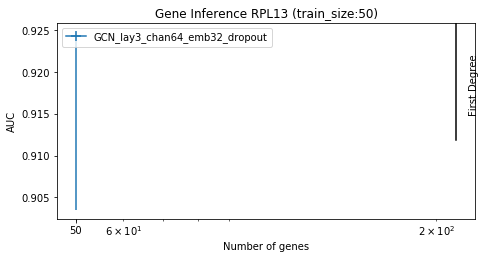

34


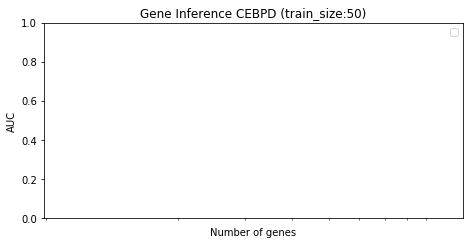

3


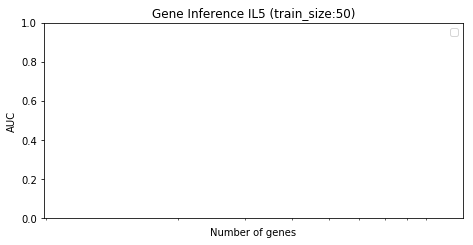

23


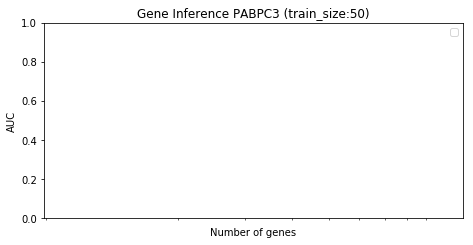

24


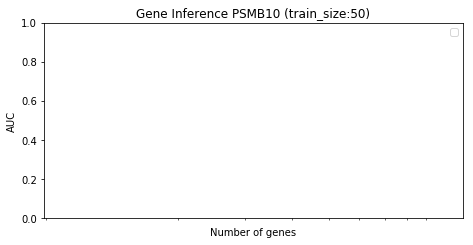

206


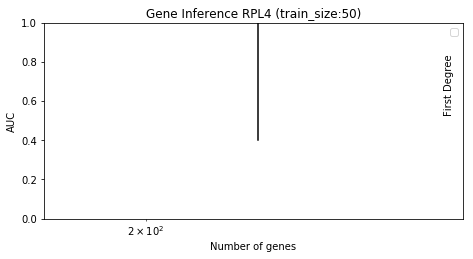

219


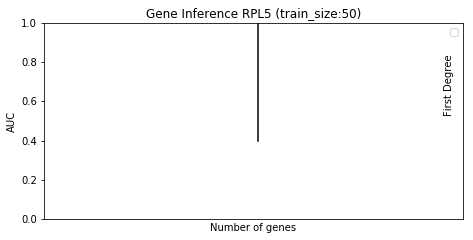

167


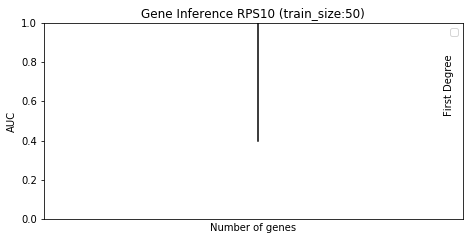

250


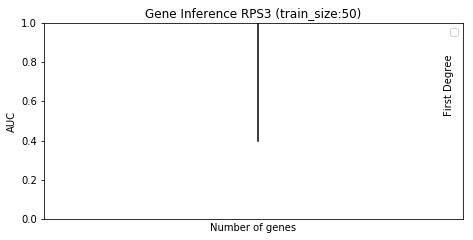

57


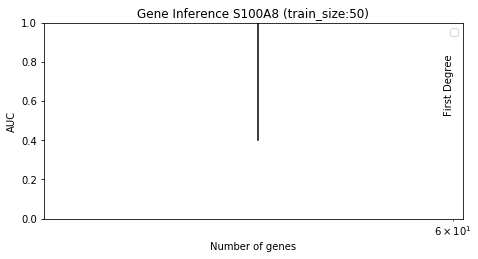

85


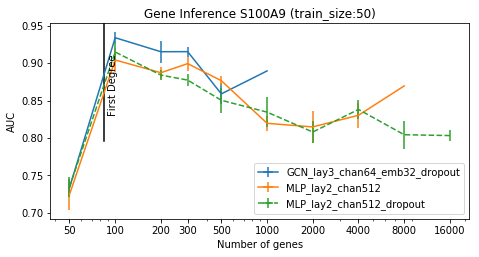

158


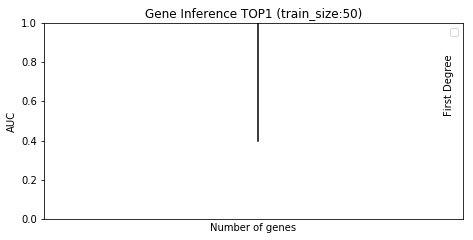

3


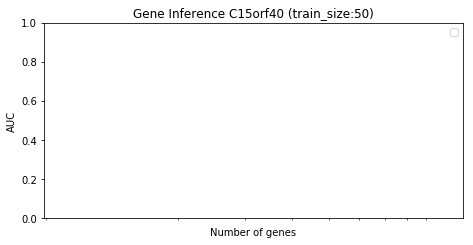

26


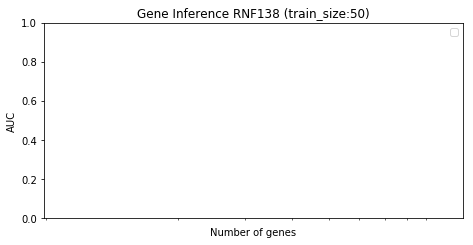

24


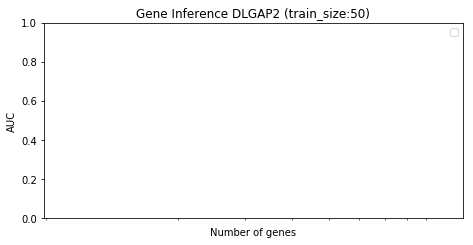

1


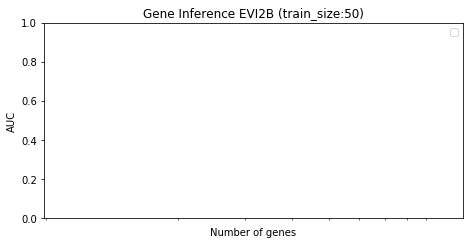

1


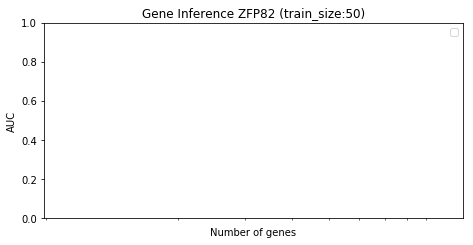

53


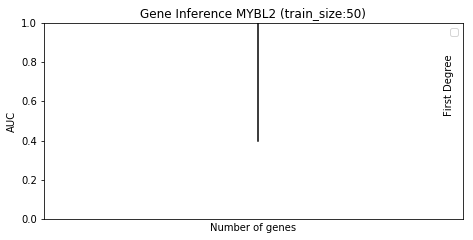

131


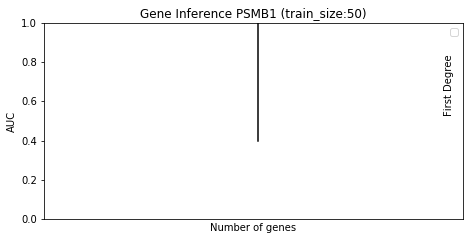

33


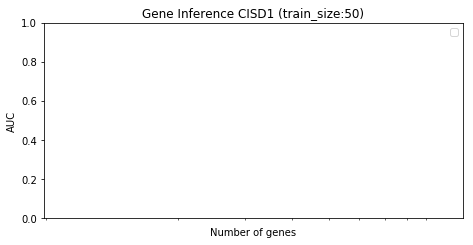

73


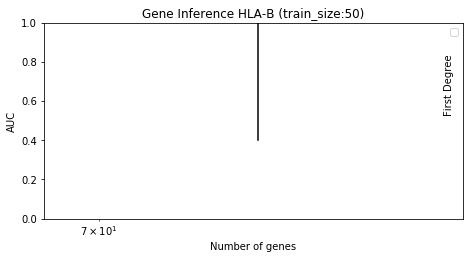

3


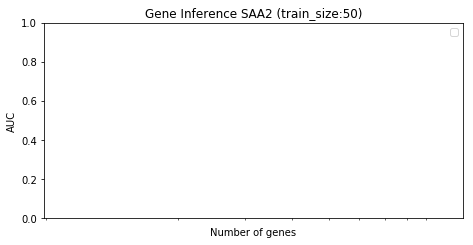

49


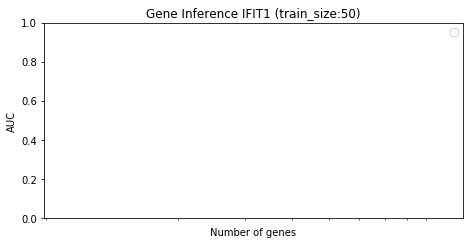

230


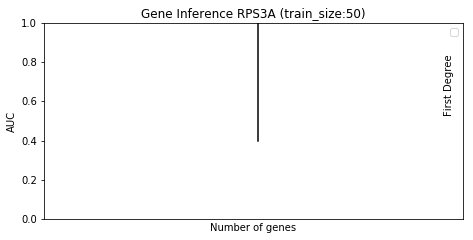

938


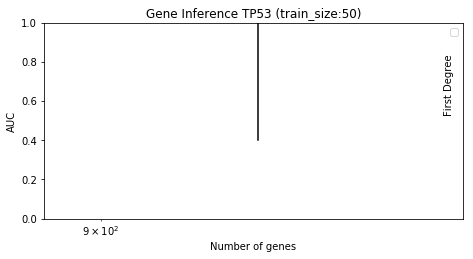

122


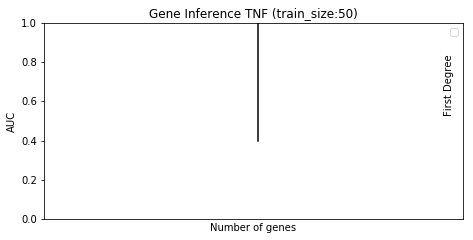

922


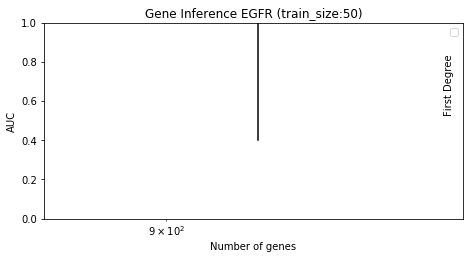

In [12]:

for plot_gene in search_genes:

    %matplotlib inline
    plt.rcParams['figure.figsize'] = (7.5, 3.6)
    plot_train_size = 50

    subset = results[(results.train_size==plot_train_size) & 
                      (results.gene==plot_gene) & 
                      (results.num_genes!=400) &      
                      (results.num_genes> 0)]


    q = subset.groupby(['model','num_genes'])['auc']

    todo = list(subset["model"].unique())
    linestyles = ['-', '-', '--', '-.', ':']
    for ls, model in enumerate(sorted(todo)):
        index = list(q.mean()[model].index)
        mean = q.mean()[model]
        stderr = q.std()[model]/np.sqrt(q.count()[model])
        displayname = model.replace("CGN","GCN")
        displayname = displayname.replace("SLR", "SNLR")
        plt.errorbar(index, mean,label=displayname, xerr=0, yerr=stderr, ls=linestyles[ls])

    plt.title("Gene Inference " + plot_gene + " (train_size:" + str(plot_train_size) +")")
    plt.ylabel("AUC")
    plt.xlabel("Number of genes")
    plt.xscale("log")
    plt.xticks(sorted(subset["num_genes"].unique()))
    formatter = matplotlib.ticker.ScalarFormatter()
    plt.gca().xaxis.set_major_formatter(formatter)

    plt.legend();
    fd = len(list(gene_graph.nx_graph.neighbors(plot_gene)))
    print fd
    if fd > 50:
        plt.axvline(fd, ymin=0.4, ymax=1.0, c="black")
        c = plt.ylim()
        plt.text(fd*1.05,c[1]-((c[1]-c[0])*0.2),'First Degree',rotation=90)


    plt.savefig("experiments/results/sgi-" + plot_gene + "-" + "train" + str(plot_train_size) + ".png", bbox_inches='tight')
    plt.show()